In [16]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv('sampled_tbc_training_data.csv')

In [3]:
df = df.copy()

# 1) Drop ID
if 'Customer_ID' in df.columns:
    df.drop(columns=['Customer_ID'], inplace=True)

In [4]:
if 'Sales_Amount' in df.columns:
    df.drop(columns=['Sales_Amount'], inplace=True)

In [5]:
if df['churn'].dtype != 'int64' and df['churn'].dtype != 'int32':
    df['churn'] = df['churn'].astype(int)

In [6]:
if 'age' in df.columns and is_numeric_dtype(df['age']):
    df['age_bucket'] = pd.qcut(df['age'], q=3, labels=['Low','Medium','High'])
else:
    print("Warning: 'age' missing or non-numeric.")

In [7]:
print("Columns now (first 20):", df.columns.tolist()[:20])
print("\nSample rows (first 5) for selected cols:")
print(df[['recency','frequency','value','age','age_bucket','units','sales','churn']].head(5))

print("\nAge bucket counts:")
print(df['age_bucket'].value_counts())
print("\nChurn distribution (sanity):")
print(df['churn'].value_counts(), "\n", df['churn'].value_counts(normalize=True))


Columns now (first 20): ['recency', 'frequency', 'value', 'age', 'units', 'Units_BLT', 'Units_FRM', 'Units_IND', 'Units_MBT', 'Units_MRT', 'Units_OTR', 'Units_PASS', 'Units_PSUV', 'Units_RLT', 'Units_SPC', 'Units_TRLR', 'Units_-', 'Units_Customer-Billed', 'Units_National Acct', 'Units_ADVANCE']

Sample rows (first 5) for selected cols:
   recency  frequency        value    age age_bucket        units  \
0     85.0        8.0   171.661250  316.0     Medium    14.000000   
1      2.0      469.0   441.328591  240.0     Medium  1516.476421   
2      4.0       18.0   826.507222  179.0        Low    74.000000   
3      6.0      179.0   424.440056  391.0       High   419.000000   
4      1.0      223.0  1670.450451  575.0       High   729.750000   

           sales  churn  
0    1373.290000      1  
1  206983.109008      0  
2   14877.130000      0  
3   75974.770000      0  
4  372510.450634      0  

Age bucket counts:
age_bucket
Low       667
Medium    667
High      666
Name: count, dtype

In [9]:
num_cols = ['recency','frequency','value','units','sales']
df[num_cols].describe().T[['mean','std','min','50%','max']]

,mean,std,min,50%,max
recency,48.858000,85.829244,1.000000,12.000000,5.610000e+02
frequency,87.221000,278.567101,1.000000,17.000000,7.240000e+03
value,480.995590,575.517781,21.960000,384.518418,1.357950e+04
units,280.374474,1119.791115,0.038593,48.749337,3.448550e+04
sales,42812.205773,149957.605515,21.960000,6812.540000,3.415385e+06


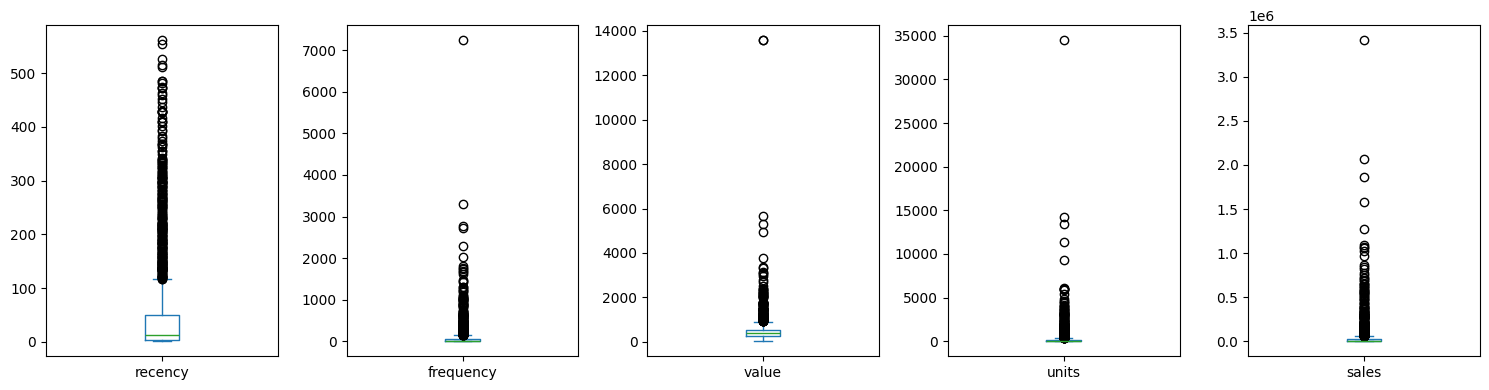

In [12]:
df[num_cols].plot(kind='box', subplots=True, layout=(1,5), figsize=(15,4), sharey=False)
plt.tight_layout()
plt.show()

In [ ]:
for c in num_cols:
    if (df[c] > 0).all():
        df[f'{c}_log'] = np.log1p(df[c])
    else:
        print(f"Skipped log for {c} because of zero/negative values")

print("Added log-transformed columns:")
print([c for c in df.columns if c.endswith('_log')])

✅ Added log-transformed columns:
['recency_log', 'frequency_log', 'value_log', 'units_log', 'sales_log']


In [17]:
base_features = [
    'recency_log','frequency_log','value_log','units_log','sales_log',
    'Channel_NR','IsProgram','NumOfPrograms'
]
X = df[base_features]
y = df['churn']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)
print("After SMOTE ->", y_train_res.value_counts().to_dict())

After SMOTE -> {1: 1310, 0: 1310}


In [20]:
log_reg = LogisticRegression(max_iter=1000, solver='lbfgs')
log_reg.fit(X_train_res, y_train_res)


LogisticRegression(max_iter=1000)

In [21]:
y_pred = log_reg.predict(X_test_scaled)
y_pred_proba = log_reg.predict_proba(X_test_scaled)[:,1]

In [22]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.80      0.86       328
           1       0.45      0.76      0.57        72

    accuracy                           0.79       400
   macro avg       0.70      0.78      0.72       400
weighted avg       0.85      0.79      0.81       400



In [23]:
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

ROC-AUC: 0.8758468834688347

Confusion Matrix:
[[262  66]
 [ 17  55]]


In [ ]:
coef_df = pd.DataFrame({
    'Feature': base_features,
    'Coefficient': log_reg.coef_[0]
})


coef_df['AbsCoef'] = np.abs(coef_df['Coefficient'])
coef_df.sort_values(by='AbsCoef', ascending=False, inplace=True)
print(coef_df[['Feature', 'Coefficient']])

         Feature  Coefficient
4      sales_log    -1.680662
0    recency_log     1.321276
7  NumOfPrograms    -0.747192
2      value_log     0.705144
5     Channel_NR    -0.303197
1  frequency_log     0.276581
3      units_log     0.191152
6      IsProgram     0.112991


In [ ]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    max_depth=None,
    class_weight='balanced_subsample',
    n_jobs=-1
)
rf.fit(X_train_res, y_train_res)

y_pred_rf = rf.predict(X_test_scaled)
y_pred_rf_proba = rf.predict_proba(X_test_scaled)[:, 1]

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_rf_proba))


feat_imp = pd.DataFrame({
    'Feature': base_features,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nTop Features by Importance:")
print(feat_imp)



Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       328
           1       0.49      0.60      0.54        72

    accuracy                           0.82       400
   macro avg       0.70      0.73      0.71       400
weighted avg       0.83      0.82      0.82       400

ROC-AUC: 0.855542852303523

Top Features by Importance:
         Feature  Importance
0    recency_log    0.328341
1  frequency_log    0.203098
3      units_log    0.163946
4      sales_log    0.158553
2      value_log    0.120766
5     Channel_NR    0.014781
7  NumOfPrograms    0.006291
6      IsProgram    0.004225


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


rf = RandomForestClassifier(random_state=42, class_weight='balanced_subsample', n_jobs=-1)


grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=2,
    n_jobs=-1
)


grid_search.fit(X_train_res, y_train_res)


print("Best parameters:", grid_search.best_params_)
print("Best ROC-AUC score (CV):", grid_search.best_score_)


best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test_scaled)
y_pred_best_proba = best_rf.predict_proba(X_test_scaled)[:,1]

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_best))
print("ROC-AUC (Test Set):", roc_auc_score(y_test, y_pred_best_proba))
print("\nConfusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_pred_best))


Fitting 5 folds for each of 108 candidates, totalling 540 fits
✅ Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
✅ Best ROC-AUC score (CV): 0.957359710972554

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       328
           1       0.48      0.58      0.53        72

    accuracy                           0.81       400
   macro avg       0.69      0.72      0.70       400
weighted avg       0.83      0.81      0.82       400

ROC-AUC (Test Set): 0.8563050474254742

Confusion Matrix (Test Set):
[[282  46]
 [ 30  42]]


In [ ]:
top_features = ['recency_log','frequency_log','value_log','units_log','sales_log']


top_features += ['Channel_NR','IsProgram','NumOfPrograms']


unit_cols = [c for c in df.columns if c.startswith('Units_') and c not in ['Units','Units_is_win_NO','Units_is_win_YES','Units_is_ev_-','Units_is_ev_NO','Units_is_ev_YES']]
corr_with_churn = df[unit_cols + ['churn']].corr()['churn'].abs().sort_values(ascending=False)
top_brand_units = list(corr_with_churn.index[1:11])  
top_features += top_brand_units

print("Selected Top Features (Total 18 so far):")
print(top_features)

✅ Selected Top Features (Total 18 so far):
['recency_log', 'frequency_log', 'value_log', 'units_log', 'sales_log', 'Channel_NR', 'IsProgram', 'NumOfPrograms', 'Units_HANKOOK', 'Units_MICHELIN', 'Units_PSUV', 'Units_RLT', 'Units_NITTO', 'Units_National Acct', 'Units_BFGOODRICH', 'Units_TOYO', 'Units_PIRELLI', 'Units_PRINX']


In [28]:
X = df[top_features]
y = df['churn']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [31]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [32]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

In [33]:
log_reg = LogisticRegression(max_iter=1000, solver='lbfgs')
log_reg.fit(X_train_res, y_train_res)

LogisticRegression(max_iter=1000)

In [34]:
y_pred_lr = log_reg.predict(X_test_scaled)
y_pred_lr_proba = log_reg.predict_proba(X_test_scaled)[:,1]

print("\nLogistic Regression (Top Features) Classification Report:")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_lr_proba))


Logistic Regression (Top Features) Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.80      0.86       328
           1       0.45      0.76      0.57        72

    accuracy                           0.79       400
   macro avg       0.69      0.78      0.71       400
weighted avg       0.85      0.79      0.81       400

ROC-AUC: 0.8791920731707318


In [35]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    class_weight='balanced_subsample',
    n_jobs=-1
)
rf.fit(X_train_res, y_train_res)

y_pred_rf = rf.predict(X_test_scaled)
y_pred_rf_proba = rf.predict_proba(X_test_scaled)[:,1]

In [ ]:
print("\nRandom Forest (Top Features) Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_rf_proba))


feat_imp = pd.DataFrame({
    'Feature': top_features,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nTop Features by Importance (Random Forest):")
print(feat_imp)


Random Forest (Top Features) Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90       328
           1       0.53      0.56      0.54        72

    accuracy                           0.83       400
   macro avg       0.71      0.72      0.72       400
weighted avg       0.83      0.83      0.83       400

ROC-AUC: 0.860984078590786

Top Features by Importance (Random Forest):
                Feature  Importance
0           recency_log    0.269465
1         frequency_log    0.125340
3             units_log    0.111379
4             sales_log    0.100847
10           Units_PSUV    0.076672
2             value_log    0.068405
9        Units_MICHELIN    0.039915
14     Units_BFGOODRICH    0.038658
11            Units_RLT    0.038624
8         Units_HANKOOK    0.033491
17          Units_PRINX    0.020380
12          Units_NITTO    0.019684
16        Units_PIRELLI    0.017339
13  Units_National Acct    0.017293
15      

In [ ]:

top_features_exp = ['recency_log','frequency_log','value_log','units_log','sales_log']


top_features_exp += ['Channel_NR','IsProgram','NumOfPrograms']


original_units = ['Units_HANKOOK', 'Units_MICHELIN', 'Units_PSUV', 'Units_RLT',
                  'Units_NITTO', 'Units_National Acct', 'Units_BFGOODRICH',
                  'Units_TOYO', 'Units_PIRELLI', 'Units_PRINX']
top_features_exp += original_units



unit_cols = [c for c in df.columns if c.startswith('Units_') and c not in top_features_exp]
corr_with_churn = df[unit_cols + ['churn']].corr()['churn'].abs().sort_values(ascending=False)
next_units = list(corr_with_churn.index[1:9])  
top_features_exp += next_units

print("Expanded Top Features (~26 features):")
print(top_features_exp)


✅ Expanded Top Features (~26 features):
['recency_log', 'frequency_log', 'value_log', 'units_log', 'sales_log', 'Channel_NR', 'IsProgram', 'NumOfPrograms', 'Units_HANKOOK', 'Units_MICHELIN', 'Units_PSUV', 'Units_RLT', 'Units_NITTO', 'Units_National Acct', 'Units_BFGOODRICH', 'Units_TOYO', 'Units_PIRELLI', 'Units_PRINX', 'Units_is_ev_NO', 'Units_is_win_NO', 'Units_is_ev_-', 'Units_COOPER', 'Units_PASS', 'Units_CONTINENTAL', 'Units_FRM', 'Units_Customer-Billed']


In [38]:
X_exp = df[top_features_exp]
y = df['churn']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X_exp, y, test_size=0.2, random_state=42, stratify=y
)

In [40]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [41]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

In [42]:
log_reg = LogisticRegression(max_iter=1000, solver='lbfgs')
log_reg.fit(X_train_res, y_train_res)

LogisticRegression(max_iter=1000)

In [43]:
y_pred_lr = log_reg.predict(X_test_scaled)
y_pred_lr_proba = log_reg.predict_proba(X_test_scaled)[:,1]

print("\nLogistic Regression (Expanded Features) Classification Report:")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_lr_proba))


Logistic Regression (Expanded Features) Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.80      0.86       328
           1       0.45      0.75      0.56        72

    accuracy                           0.79       400
   macro avg       0.69      0.77      0.71       400
weighted avg       0.85      0.79      0.81       400

ROC-AUC: 0.877371273712737


In [44]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    class_weight='balanced_subsample',
    n_jobs=-1
)
rf.fit(X_train_res, y_train_res)

RandomForestClassifier(class_weight='balanced_subsample', n_estimators=300,
                       n_jobs=-1, random_state=42)

In [ ]:
y_pred_rf = rf.predict(X_test_scaled)
y_pred_rf_proba = rf.predict_proba(X_test_scaled)[:,1]

print("\nRandom Forest (Expanded Features) Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_rf_proba))


feat_imp = pd.DataFrame({
    'Feature': top_features_exp,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nTop Features by Importance (Random Forest):")
print(feat_imp)


Random Forest (Expanded Features) Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       328
           1       0.49      0.54      0.52        72

    accuracy                           0.82       400
   macro avg       0.70      0.71      0.70       400
weighted avg       0.82      0.82      0.82       400

ROC-AUC: 0.8573424796747968

Top Features by Importance (Random Forest):
                  Feature  Importance
0             recency_log    0.210366
1           frequency_log    0.113249
3               units_log    0.072361
19        Units_is_win_NO    0.070947
20          Units_is_ev_-    0.069872
22             Units_PASS    0.056143
4               sales_log    0.055750
2               value_log    0.048976
10             Units_PSUV    0.039653
25  Units_Customer-Billed    0.039180
18         Units_is_ev_NO    0.031925
11              Units_RLT    0.026811
9          Units_MICHELIN    0.022317
8         

In [62]:
X = df[top_features_exp]
y = df['churn']

In [63]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [64]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [65]:
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
xgb_clf = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(len(y_train_res[y_train_res==0]) / len(y_train_res[y_train_res==1])),
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

In [66]:
xgb_clf.fit(X_train_res, y_train_res)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [01:55:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [67]:
y_pred_xgb = xgb_clf.predict(X_test)
y_pred_xgb_proba = xgb_clf.predict_proba(X_test)[:,1]

print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_xgb_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90       328
           1       0.53      0.50      0.51        72

    accuracy                           0.83       400
   macro avg       0.71      0.70      0.71       400
weighted avg       0.83      0.83      0.83       400

ROC-AUC: 0.8512025745257452
Confusion Matrix:
 [[296  32]
 [ 36  36]]


In [68]:
feat_imp_xgb = pd.DataFrame({
    'Feature': top_features_exp,
    'Importance': xgb_clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop Features by Importance (XGBoost):")
print(feat_imp_xgb.head(10))


Top Features by Importance (XGBoost):
            Feature  Importance
0       recency_log    0.118610
1     frequency_log    0.103041
5        Channel_NR    0.063787
19  Units_is_win_NO    0.059301
17      Units_PRINX    0.054301
3         units_log    0.048908
16    Units_PIRELLI    0.038674
12      Units_NITTO    0.038345
15       Units_TOYO    0.035234
6         IsProgram    0.033325


In [ ]:
from sklearn.model_selection import GridSearchCV


param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
}


xgb_clf_tune = xgb.XGBClassifier(
    scale_pos_weight=(len(y_train_res[y_train_res==0]) / len(y_train_res[y_train_res==1])),
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)


grid_search = GridSearchCV(
    estimator=xgb_clf_tune,
    param_grid=param_grid,
    scoring='roc_auc',   
    cv=3,
    verbose=2,
    n_jobs=-1
)


grid_search.fit(X_train_res, y_train_res)


print("Best parameters:", grid_search.best_params_)
print("Best ROC-AUC score (CV):", grid_search.best_score_)


best_xgb = grid_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
y_pred_xgb_proba = best_xgb.predict_proba(X_test)[:,1]

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC (Test Set):", roc_auc_score(y_test, y_pred_xgb_proba))
print("Confusion Matrix (Test Set):\n", confusion_matrix(y_test, y_pred_xgb))


Fitting 3 folds for each of 729 candidates, totalling 2187 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [02:10:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Best parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 400, 'subsample': 0.7}
✅ Best ROC-AUC score (CV): 0.9681103476727085

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       328
           1       0.53      0.47      0.50        72

    accuracy                           0.83       400
   macro avg       0.71      0.69      0.70       400
weighted avg       0.82      0.83      0.83       400

ROC-AUC (Test Set): 0.8504827235772358
Confusion Matrix (Test Set):
 [[298  30]
 [ 38  34]]


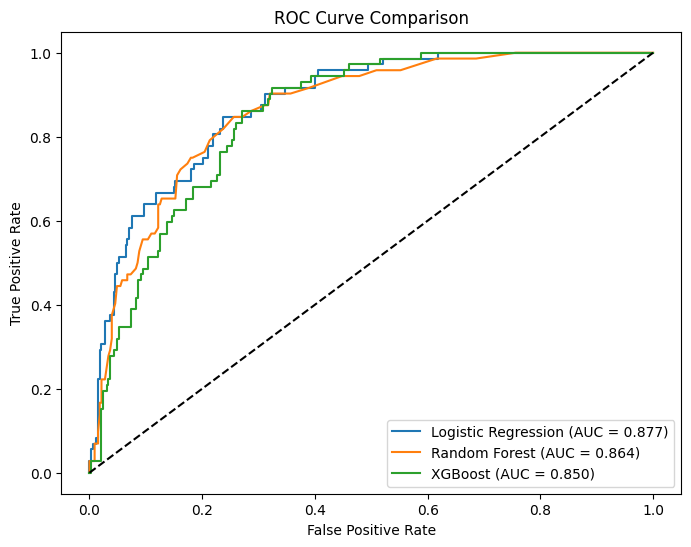

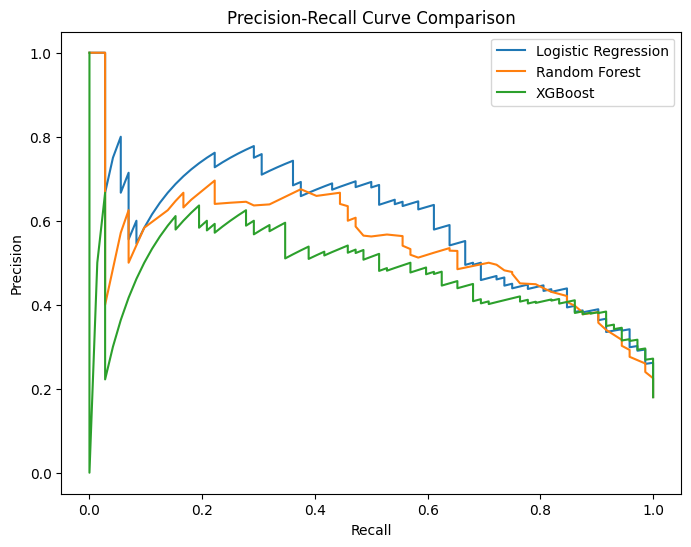

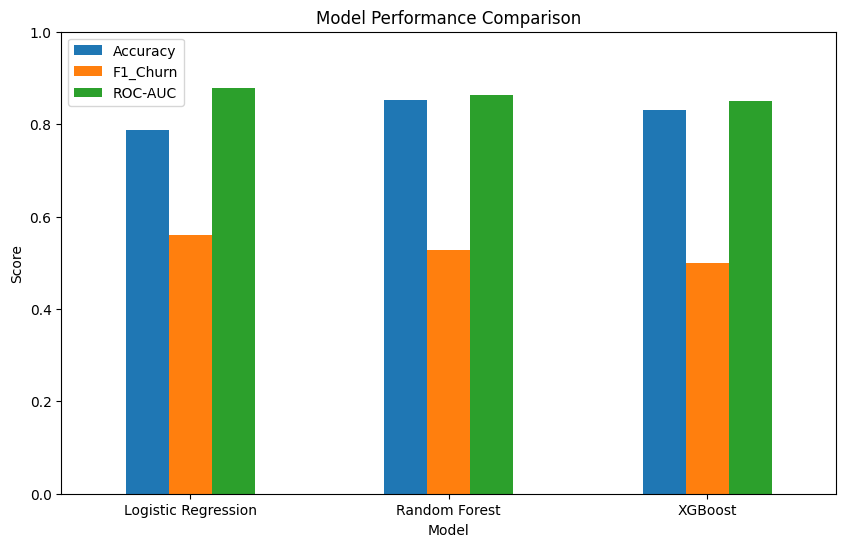

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)



models = {
    'Logistic Regression': log_reg,
    'Random Forest': rf_clf,
    'XGBoost': best_xgb
}

y_preds_proba = {name: model.predict_proba(X_test_scaled if name=='Logistic Regression' else X_test)[:,1]
                 for name, model in models.items()}




plt.figure(figsize=(8,6))
for name, y_prob in y_preds_proba.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0,1],[0,1],'k--')  
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()




plt.figure(figsize=(8,6))
for name, y_prob in y_preds_proba.items():
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.plot(recall, precision, label=name)

plt.title('Precision-Recall Curve Comparison')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()




from sklearn.metrics import f1_score, accuracy_score

metrics_summary = []
for name, y_prob in y_preds_proba.items():
    y_pred = (y_prob >= 0.5).astype(int)
    metrics_summary.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1_Churn': f1_score(y_test, y_pred, pos_label=1),
        'ROC-AUC': roc_auc_score(y_test, y_prob)
    })

metrics_df = pd.DataFrame(metrics_summary)
metrics_df.set_index('Model', inplace=True)
metrics_df.plot(kind='bar', figsize=(10,6), ylim=(0,1))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.show()


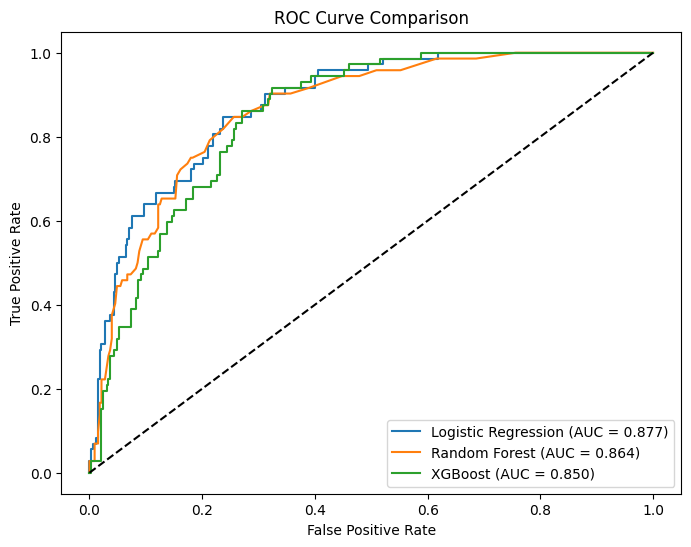

In [79]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
plt.figure(figsize=(8,6))
for name, y_prob in y_preds_proba.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0,1],[0,1],'k--')  # diagonal line
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

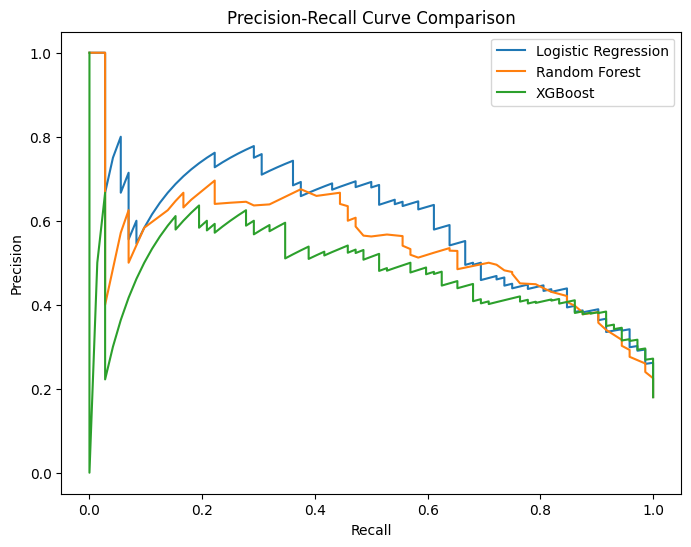

In [80]:
plt.figure(figsize=(8,6))
for name, y_prob in y_preds_proba.items():
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.plot(recall, precision, label=name)

plt.title('Precision-Recall Curve Comparison')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()


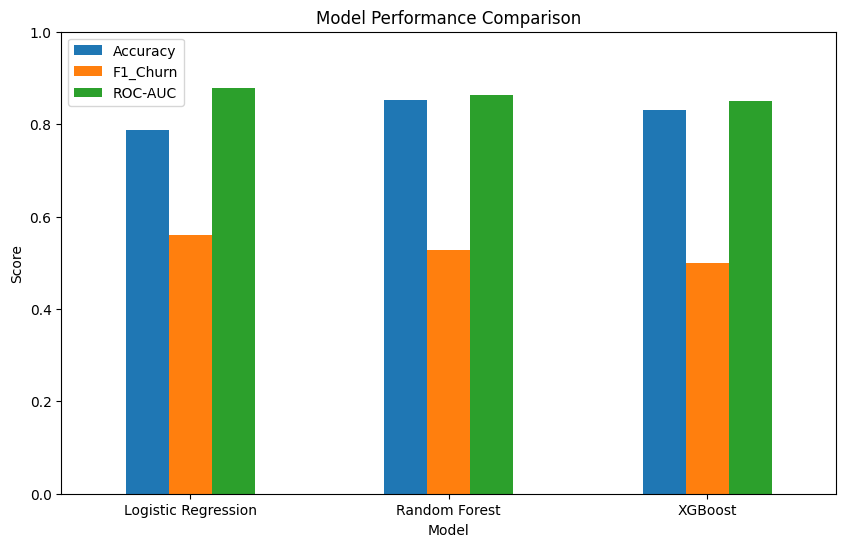

In [81]:
from sklearn.metrics import f1_score, accuracy_score

metrics_summary = []
for name, y_prob in y_preds_proba.items():
    y_pred = (y_prob >= 0.5).astype(int)
    metrics_summary.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1_Churn': f1_score(y_test, y_pred, pos_label=1),
        'ROC-AUC': roc_auc_score(y_test, y_prob)
    })

metrics_df = pd.DataFrame(metrics_summary)
metrics_df.set_index('Model', inplace=True)
metrics_df.plot(kind='bar', figsize=(10,6), ylim=(0,1))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.show()